# Last Hope of S4
- Test on pre-trained model
- Extract top K AP*coef frames
    - For these frames, extract features
    - For these features, use one-class SVM
- Down sample for close and far point
- Train

## 1. Eval
Use code in ``test.py`` and ``self_eval/s4_tule1.py``

In [1]:
import os
import numpy as np
import sys
from sklearn import svm
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# read AP*coef score file
model_type = 'voxel_rcnn_car'
epoch_str = '160'
score_path = './../../tools/self_eval/'+model_type + '_' + epoch_str + '_0.7_hard_result.txt' 

In [2]:
top_K = 100
test_scores = []
# score file format: idx score
with open(score_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        idx, score = line.split(' ')
        test_scores.append((idx, float(score)))

test_scores = sorted(test_scores, key=lambda x: x[1], reverse=True)
outter_idxs = set([x[0] for x in test_scores[:top_K]])

## 2. Sparse Conv

In [3]:
from voxelize import *

data_dir = '/home/jiazx_ug/OpenPCDet/data/kitti/training/velodyne/'
label_dir = '/home/jiazx_ug/OpenPCDet/data/kitti/training/label_2/'
idx_path = '/home/jiazx_ug/OpenPCDet/data/kitti/ImageSets/train.txt'
ckpt_path = '/home/jiazx_ug/OpenPCDet/output/kitti_models/'+model_type+'/C_S22/ckpt/checkpoint_epoch_160.pth'
# idx_list = [str(data.split('.')[0]) for data in os.listdir(data_dir)]
# idx_list.sort()
idx_list = []
with open(idx_path, 'r') as f:
    idx_list = f.readlines()
idx_list = [x.strip() for x in idx_list]
len(idx_list)

10745

In [4]:
label_dict = {'Car':0, 'Pedestrian':1, 'Rider':2, 'Truck':3, 'Van':4}
vsize_xyz = np.array([0.5, 0.5, 1])       
coors_range_xyz = np.array([-70.4, -40, -3, 70.4, 40, 1])  
num_point_features = 4                                 
max_num_points_per_voxel = 5               
max_num_voxels = 16000
input_channels = 4

grid_size = get_grid_size(coors_range_xyz, vsize_xyz)
backbone = input_backbone(input_channels, grid_size)
backbone = load_model_params(ckpt_path, backbone)
checker = isPointInQuadrangle()

In [5]:
all_features = []
all_labels = []
all_idxs = []
for idx in tqdm(idx_list):
    data_path = data_dir + idx + '.bin'
    label_path = label_dir + idx + '.txt'
    
    points = read_data(data_path)
    voxels, voxel_indices, num_points = create_voxel(points, vsize_xyz, coors_range_xyz,num_point_features ,max_num_points_per_voxel, max_num_voxels)
    input_feature, input_indices = get_input_feature(voxels, num_points, voxel_indices, backbone)
    indices_3d = indices_to_3d(input_indices, grid_size)

    corners_3Ds, label_obj = read_label(label_path)
    corners_voxelaxis = corners_to_voxelaxis(corners_3Ds, coors_range_xyz, vsize_xyz)
    feature_keys = get_inner_voxel(corners_voxelaxis, checker)
    features, labels = get_inner_voxel_feature(input_feature, indices_3d, feature_keys, grid_size, label_obj)
    all_idxs += [idx] * len(features)
    all_features += features
    all_labels += labels

100%|██████████| 10745/10745 [10:59<00:00, 16.30it/s]


# 3.Fit SVM

In [6]:
# select train data, use the idx in select_idxs
train_features = []
# all_features, all_idxs 相互对应，all_idxs的值为同下标的all_features的idx
# 1. 遍历all_idxs，如果idx在select_idxs中，则将对应的all_features加入train_features
for idx, feature in zip(all_idxs, all_features):
    if idx in outter_idxs:
        train_features.append(feature)
train_features = np.array(train_features)

In [7]:
train_features.shape

(35371, 16)

In [8]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05)
clf.fit(train_features)
# save model
import pickle
model_path = './one_class_svm_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)


# # load model
# with open(model_path, 'rb') as f:
#     clf = pickle.load(f)


In [9]:
distcanes = clf.decision_function(all_features)
distcanes_show = np.array(distcanes)
up = distcanes_show[distcanes_show>0]
down = distcanes_show[distcanes_show<0]
print('up:', len(up), 'down:', len(down))

up: 4467613 down: 646010


/tmp/ipykernel_3188768/3969512794.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(up,bins=200, hist=True, kde=True, label='normal')


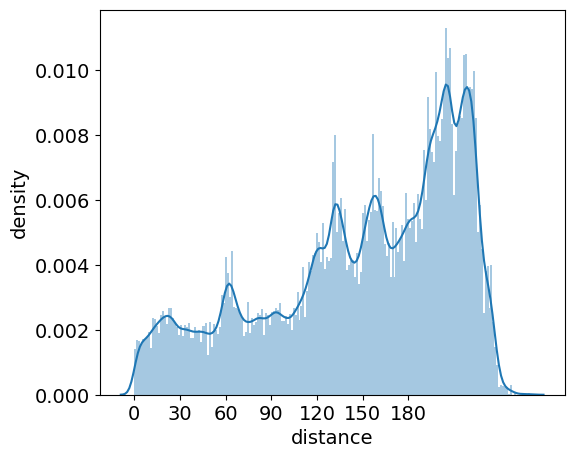

/tmp/ipykernel_3188768/3969512794.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(down,bins=200, hist=True, kde=True, label='abnormal')


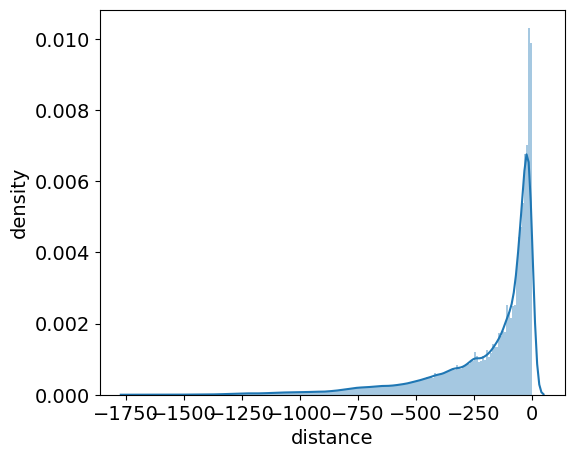

In [10]:
fig = plt.figure(figsize=(6, 5))
sns.distplot(up,bins=200, hist=True, kde=True, label='normal')
plt.xticks(np.arange(0, 210, 30),fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('distance', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.savefig('./up_B.pdf')
plt.show()
fig = plt.figure(figsize=(6, 5))
sns.distplot(down,bins=200, hist=True, kde=True, label='abnormal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('distance', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.savefig('./down_B.pdf')
plt.show()

# 4. Statistics

In [11]:
max_up = np.max(up)
min_down = np.min(down)
# 归一化，然后根据idx统计每个idx的feature的distance的和
distances_norm = []
for dist in distcanes:
    if dist > 0:
        distances_norm.append(dist/max_up)
    else:
        distances_norm.append(-dist/min_down)

up_down_dict = {}
for idx, dist in zip(all_idxs, distances_norm):
    if idx not in up_down_dict:
        up_down_dict[idx] = (0,0)
    if dist > 0:
        up_down_dict[idx] = (up_down_dict[idx][0] + dist, up_down_dict[idx][1])
    else:
        up_down_dict[idx] = (up_down_dict[idx][0], up_down_dict[idx][1] + dist)

up_down_dict: 10613


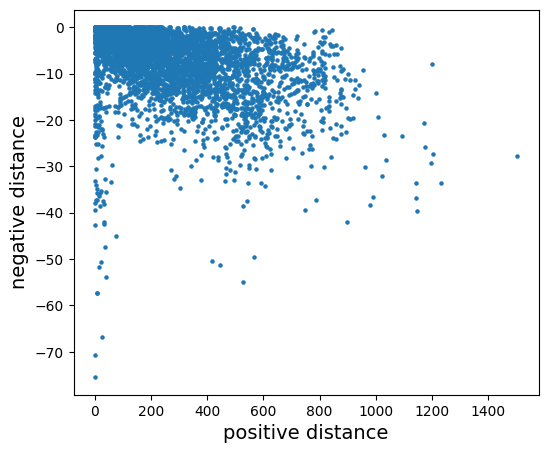

In [12]:
print('up_down_dict:', len(up_down_dict))
up_down = []
for idx in up_down_dict:
    up_down.append(up_down_dict[idx])
up_down = np.array(up_down)
fig = plt.figure(figsize=(6, 5))

# 随机取1/10的点
rand_idxs = np.random.choice(up_down.shape[0], int(up_down.shape[0]*0.5), replace=False)

plt.scatter(up_down[rand_idxs][:,0], up_down[rand_idxs][:,1], s=5)
plt.xlabel('positive distance', fontsize=14)
plt.ylabel('negative distance', fontsize=14)
plt.savefig('./scatter.pdf')
plt.show()

In [13]:
# 计算positive distance>600且negative distance<-250的idx
outter_idxs = []
inner_idxs = []
for idx in up_down_dict:
    if up_down_dict[idx][0] > 300 or up_down_dict[idx][1] < -12:
        outter_idxs.append(idx)
    else:
        inner_idxs.append(idx)
# 随机挑选50%的outter_idxs，与inner_idxs合并
outter_idxs = np.random.choice(outter_idxs, int(len(outter_idxs)/2), replace=False)
last_select_idxs = np.concatenate((outter_idxs, inner_idxs))
print('last_select_idxs:', len(last_select_idxs))
print('origin',len(idx_list))

save_path = './last_hope_s4/train.txt'
with open(save_path, 'w') as f:
    for idx in last_select_idxs:
        f.write(idx+'\n')

save_path = './last_hope_s4/val.txt'
with open(save_path, 'w') as f:
    for idx in last_select_idxs:
        f.write(idx+'\n')

last_select_idxs: 8624
origin 10745
